In [578]:
import pandas as pd
import polars as pl
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np

In [580]:
df = pl.read_csv('../new_csv/output_dataset.csv', infer_schema_length=None)
df = df.to_pandas()
df = df[df['NumPlayers'] == 2.0]
df = df.dropna(axis=1)
df = df.drop(columns=df.columns[(df == 'NULL').any()])
pl.from_pandas(df).write_csv('output_dataset.csv')

In [581]:
df = pl.read_csv('output_dataset.csv')
df = df.select(df.columns[0:2] + df.columns[6:])
df = df.select([col.name for col in df.select(pl.all().n_unique() > 1) if col.all()])
df = df.group_by('GameRulesetName', 'Id').last()
df = df.to_pandas()

identifier = df[['GameRulesetName', 'Id']]
X = df.drop(columns=['GameRulesetName', 'Id'])

the elbow is at parameter 30


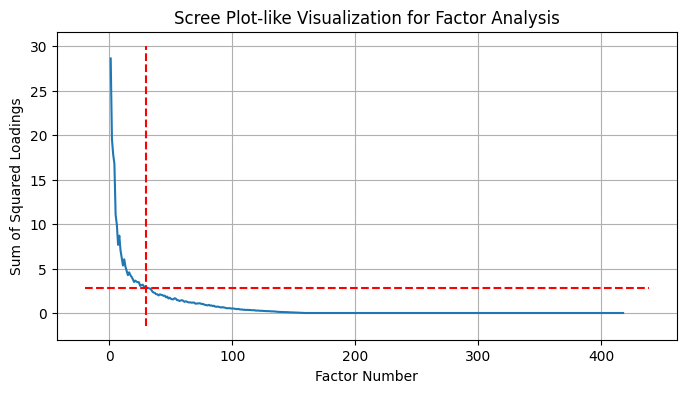

In [593]:
from sklearn.decomposition import FactorAnalysis

scaler = StandardScaler()
fa = FactorAnalysis(n_components=len(X))
pipeline = Pipeline([('scaling', scaler), ('fa', fa)])
pipeline.fit_transform(X)

loadings = fa.components_
squared_loadings = np.sum(loadings ** 2, axis=1)

optimal_factors = 30
print(f"the elbow is at parameter {optimal_factors}")

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(squared_loadings) + 1), squared_loadings)
plt.xlabel('Factor Number')
plt.ylabel('Sum of Squared Loadings')
plt.vlines(optimal_factors, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='red')
plt.hlines(squared_loadings[optimal_factors], plt.xlim()[0], plt.xlim()[1], linestyles='dashed', colors='red')
plt.title('Scree Plot-like Visualization for Factor Analysis')
plt.grid()
plt.show()

fa_optimal = FactorAnalysis(n_components=optimal_factors)
pipeline = Pipeline([('scaling', scaler), ('fa', fa_optimal)])
x_new = pipeline.fit_transform(X)

In [594]:
print(x_new.shape)
df_new = pd.DataFrame(x_new)
df_new = pd.concat([identifier, df_new], axis=1)
df_new.to_csv('MABGames.csv')
print(df_new)

(1379, 30)
                                        GameRulesetName    Id         0  \
0     Ludus_CoriovalliJanes_Soppi_-_No_Extension_No_...  1840 -0.073968   
1     Ludus_CoriovalliHaretavl_Three_Dogs_Two_Hares_...  1883 -0.059866   
2     Ludus_CoriovalliHaretavl_Four_Dogs_Two_Hares_S...  1851 -0.092771   
3          The_Concentration_GameTwo_Counters_Described   234 -0.125161   
4                                              Kubuguza   276 -0.078155   
...                                                 ...   ...       ...   
1374  Misoro_Tsoro_Additional_CaptureExtra_Counters_...  1293 -0.078155   
1375                                          FairKalah  1665 -0.106359   
1376                       KpoMomolu_Massaquoi_Observed   280 -0.106359   
1377                         Konane8x8_Konane_Suggested  1630 -0.008159   
1378                                              Kalah    68 -0.106359   

             1         2         3         4         5         6         7  \
0    -0.00

In [596]:
import random

random.seed(177013)

expansion = ['ProgressiveHistory', 'UCB1', 'UCB1GRAVE', 'UCB1Tuned']
exploration = ['0.1', '0.6', 'sqrt2']
play_out = ['Random0', 'Random4', 'Random200', 'NST', 'MAST']


def get_environment(games):
    context = []
    game_id = games['Id']
    random_game = random.choice(game_id)
    print(f"random game: {games[games['Id'] == random_game]['GameRulesetName'].to_numpy()[0]}")
    game = games[games['Id'] == random_game]
    game = game[game.columns[2:]]
    game = game.to_numpy()
    for i in range(len(game)):
        context = context + game[i].tolist()

    expansion_onehot = np.zeros(len(expansion))
    expansion_index = random.randrange(len(expansion))
    expansion_onehot[expansion_index] = 1
    context = context + expansion_onehot.tolist()

    exploration_constant = random.choice(exploration)
    context = context + [exploration_constant]

    play_out_onehot = np.zeros(len(play_out))
    play_out_index = random.randrange(len(play_out))
    play_out_onehot[play_out_index] = 1
    context = context + play_out_onehot.tolist()

    print(f"opponent strategy: {expansion[expansion_index]} {exploration_constant} {play_out[play_out_index]}")
    return context

In [592]:
print(get_environment(df_new))


random game: RatioGame_VII_Easy_Capturing_Game_Described
opponent strategy: ProgressiveHistory 0.6 MAST
[-0.12465641506998745, -0.017508956872628056, -0.41372623857399266, -0.10700352128342155, 2.203438740603757, -3.340630113358438, 0.4023722427038903, -0.3689020853734504, -2.271411974506753, -0.8137359698080776, 0.5531640247596776, -1.1868898935473118, -0.6988884014707102, -0.47438159437124294, -1.3058918329926388, -0.7033858244399712, -0.06426693739445737, -0.053281676779121726, -0.5473621755761097, -0.14237992173472916, 1.098178090508937, 0.9281256168176073, -0.4654187668291274, 0.15828585633081751, -0.4131587090529643, -0.25342568037484986, 0.0755583154596936, 0.540661131242011, 0.03947818229714527, -1.1385067392882156, 1.0, 0.0, 0.0, 0.0, '0.6', 0.0, 0.0, 0.0, 0.0, 1.0]


In [608]:
import math

alpha = 0.01


def softmax(wanted, PI):
    if wanted not in PI:
        raise RuntimeError("desired value is not in the list of possible values")
    denominator = 0
    for p in PI:
        denominator += math.exp(p)

    numerator = math.exp(wanted)

    return numerator / denominator

In [617]:
df = pl.read_csv('../new_csv/output_dataset.csv', infer_schema_length=None)
df = df[df.columns[0:12]]
df = df.filter((pl.col('agent1_AI_type') == 'MCTS') & (pl.col('agent2_AI_type') == 'MCTS'))
df = df.group_by(
    ['GameRulesetName', 'Id', 'agent1_Expansion', 'agent1_Exploration', 'agent1_Play-out', 'agent2_Expansion',
     'agent2_Exploration', 'agent2_Play-out']).agg(pl.col('utility_agent1').sum(), pl.col('utility_agent2').sum())


In [618]:
print(df)
df_agent1 = df[['GameRulesetName', 'Id', 'agent1_Expansion', 'agent1_Exploration', 'agent1_Play-out', 'utility_agent1']]
df_agent2 = df[['GameRulesetName', 'Id', 'agent2_Expansion', 'agent2_Exploration', 'agent2_Play-out', 'utility_agent2']]

shape: (15_887, 10)
┌────────────┬──────┬────────────┬────────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ GameRulese ┆ Id   ┆ agent1_Exp ┆ agent1_Exp ┆ … ┆ agent2_Exp ┆ agent2_Pl ┆ utility_a ┆ utility_a │
│ tName      ┆ ---  ┆ ansion     ┆ loration   ┆   ┆ loration   ┆ ay-out    ┆ gent1     ┆ gent2     │
│ ---        ┆ i64  ┆ ---        ┆ ---        ┆   ┆ ---        ┆ ---       ┆ ---       ┆ ---       │
│ str        ┆      ┆ str        ┆ f64        ┆   ┆ f64        ┆ str       ┆ f64       ┆ f64       │
╞════════════╪══════╪════════════╪════════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ Adugo      ┆ 37   ┆ UCB1Tuned  ┆ 1.414214   ┆ … ┆ 0.6        ┆ NST       ┆ 10.0      ┆ -10.0     │
│ Adugo      ┆ 37   ┆ UCB1Tuned  ┆ 1.414214   ┆ … ┆ 0.6        ┆ NST       ┆ 9.0       ┆ -9.0      │
│ Asalto     ┆ 1368 ┆ UCB1       ┆ 0.1        ┆ … ┆ 1.414214   ┆ NST       ┆ 1.0       ┆ -1.0      │
│ Bagh_Bandi ┆ 898  ┆ Progressiv ┆ 0.1        ┆ … ┆ 1.414214   ┆ Random